In [1]:
# Notebook 02 - EDA & Visualizations (Cell 1)
import os, math, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import torchvision
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

#The paths
ROOT="/content/drive/MyDrive/food-10/food-10"
CSV_DIR=os.path.join(ROOT, "prepared_splits")
OUT_DIR="/content/food10_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

print("CSV_DIR:", CSV_DIR)
print("OUT_DIR:", OUT_DIR)

Mounted at /content/drive
CSV_DIR: /content/drive/MyDrive/food-10/food-10/prepared_splits
OUT_DIR: /content/food10_outputs


In [2]:
#Cell 2- load train/val CSVs and print basic info
train_df=pd.read_csv(os.path.join(CSV_DIR, "train.csv"))
val_df=pd.read_csv(os.path.join(CSV_DIR, "val.csv"))

print("Train rows:", len(train_df))
print("Val rows  :", len(val_df))
print("Columns:", train_df.columns.tolist())
#Classes and sample counts
classes=sorted(train_df['class'].unique())
print("Num classes:", len(classes))
print("Classes:", classes)
print("Per-class counts (train):")
print(train_df['class'].value_counts())

Train rows: 6000
Val rows  : 1500
Columns: ['path', 'class', 'fullpath']
Num classes: 10
Classes: ['cannoli', 'ceviche', 'crab_cakes', 'frozen_yogurt', 'gnocchi', 'grilled_cheese_sandwich', 'onion_rings', 'pork_chop', 'ravioli', 'spaghetti_bolognese']
Per-class counts (train):
class
onion_rings                600
frozen_yogurt              600
ravioli                    600
gnocchi                    600
crab_cakes                 600
grilled_cheese_sandwich    600
pork_chop                  600
ceviche                    600
cannoli                    600
spaghetti_bolognese        600
Name: count, dtype: int64


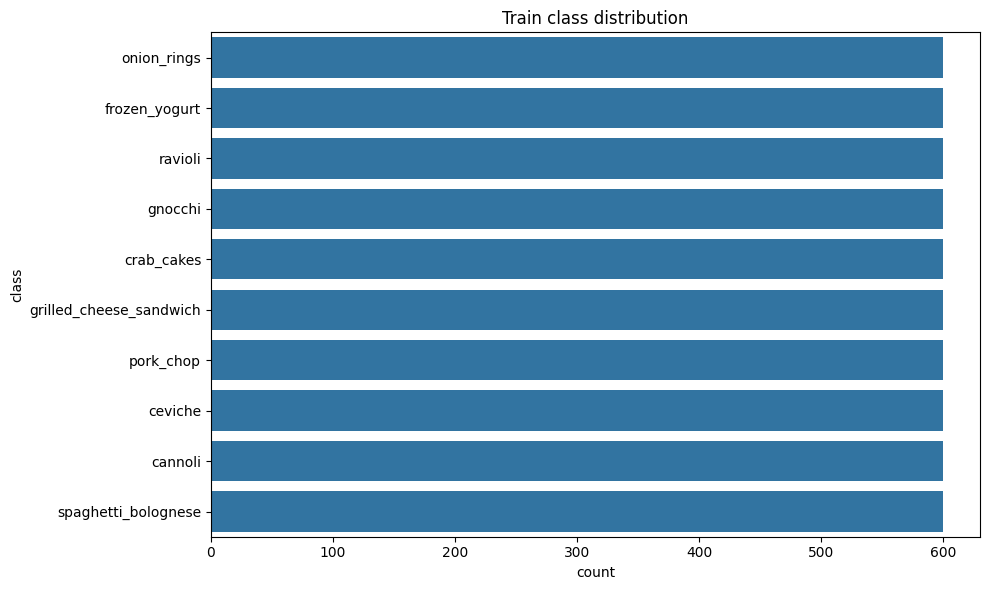

In [3]:
#Cell 3- Class distribution plot
plt.figure(figsize=(10,6))
sns.countplot(y='class', data=train_df, order=train_df['class'].value_counts().index)
plt.title("Train class distribution")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "train_class_distribution.png"), dpi=150)
plt.show()

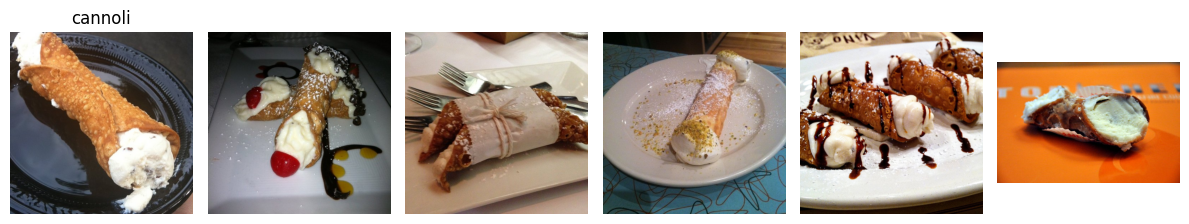

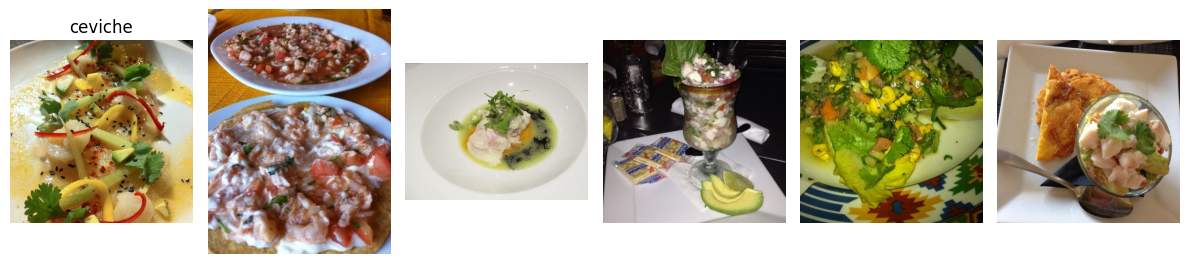

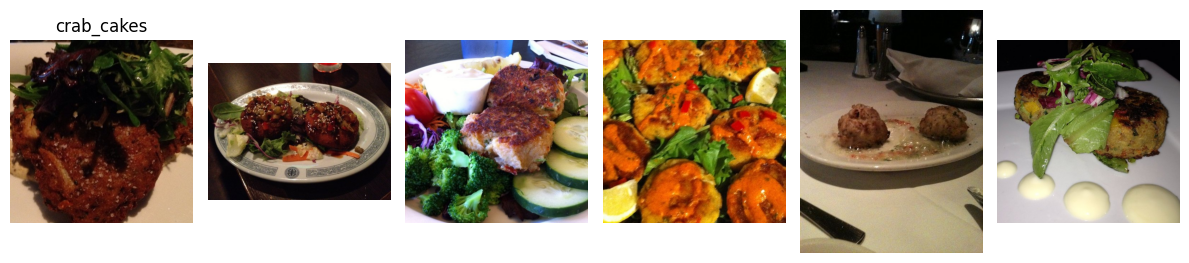

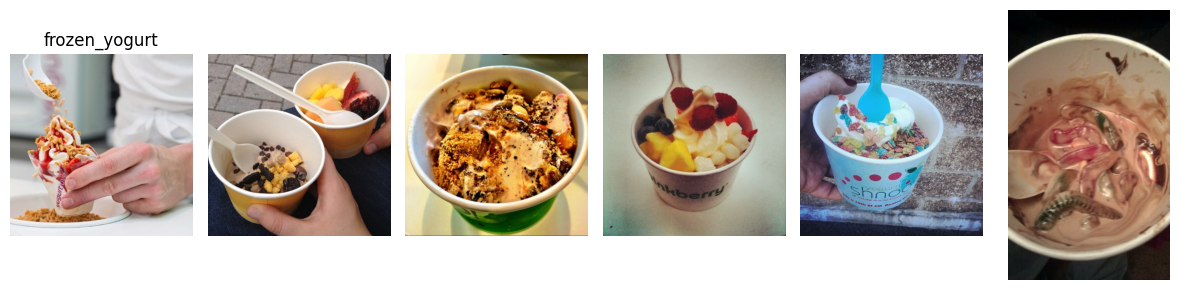

In [4]:
# Cell 4- Show sample images per class
def show_samples_for_class(df, cls, n=6):
    files = df[df['class']==cls]['fullpath'].tolist()[:n]
    cols = n
    plt.figure(figsize=(cols*2, 3))
    for i,f in enumerate(files):
        img = Image.open(f).convert('RGB')
        plt.subplot(1,cols,i+1)
        plt.imshow(img); plt.axis('off'); plt.title(cls if i==0 else "")
    plt.tight_layout()
    plt.show()

#Display first 4 classes with 6 samples each
sample_classes = classes[:4]
for c in sample_classes:
    show_samples_for_class(train_df, c, n=6)

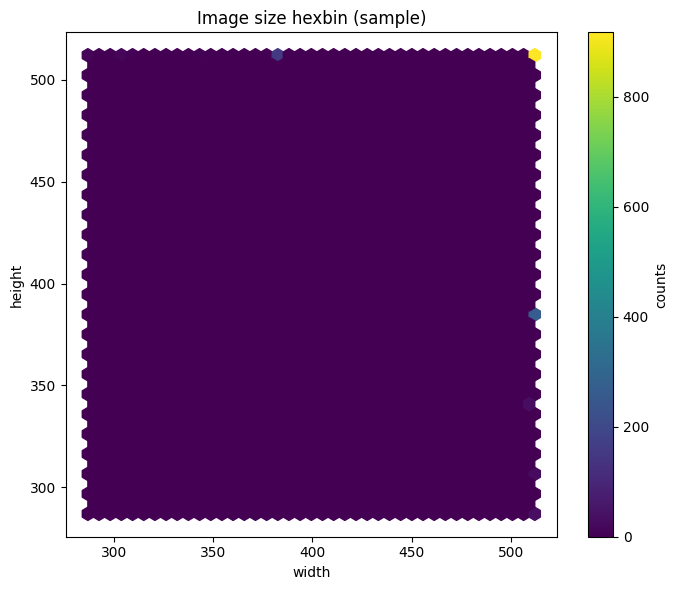

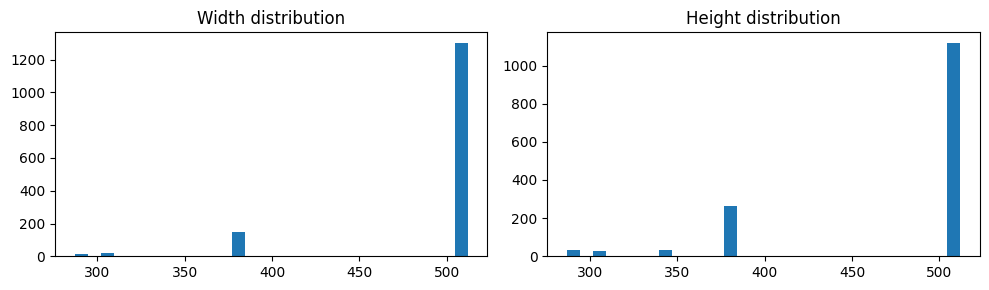

Width median/mean: 512.0 493.258
Height median/mean: 512.0 475.104


In [18]:
#Cell 5- Image resolution distribution (sampling for speed)
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

sample_n=min(1500, len(train_df))
samps=train_df['fullpath'].sample(n=sample_n, random_state=42).tolist()
widths=[]
heights=[]
for p in samps:
    try:
        im = Image.open(p)
        w,h = im.size  # PIL: (width, height)
        widths.append(w); heights.append(h)
    except Exception:
        continue
widths=np.array(widths)
heights=np.array(heights)

#2D density: hexbin (better when many overlapping points)
plt.figure(figsize=(7,6))
plt.hexbin(widths, heights, gridsize=40, cmap='viridis')
plt.colorbar(label='counts')
plt.xlabel("width"); plt.ylabel("height"); plt.title("Image size hexbin (sample)")
plt.tight_layout()
plt.show()

#Histograms for width and height
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(widths, bins=30)
plt.title("Width distribution")
plt.subplot(1,2,2)
plt.hist(heights, bins=30)
plt.title("Height distribution")
plt.tight_layout()
plt.show()

#Print stats
print("Width median/mean:", np.median(widths), np.mean(widths))
print("Height median/mean:", np.median(heights), np.mean(heights))

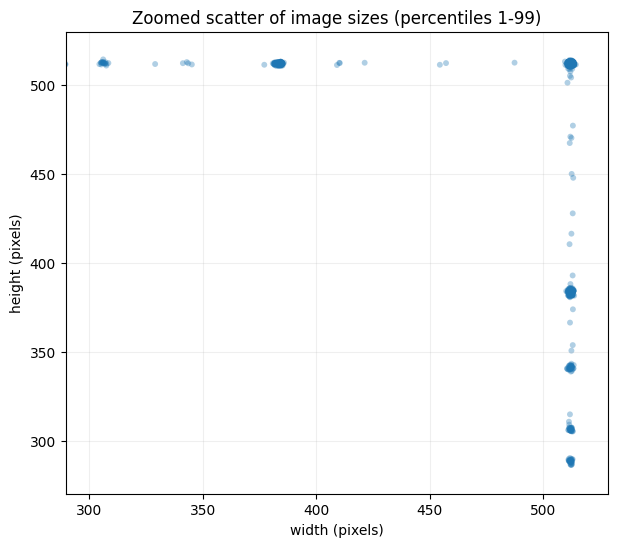

In [17]:
#Centered/zoomed scatter for image widths vs heights
import numpy as np
import matplotlib.pyplot as plt
#assume widths and heights are numpy arrays (from earlier)
#if they are lists convert: widths = np.array(widths); heights = np.array(heights)

#1) Choose percentile window to focus on the central mass (e.g. 1st to 99th)
p_low,p_high=1, 99
xlo,xhi=np.percentile(widths,[p_low, p_high])
ylo,yhi=np.percentile(heights,[p_low, p_high])

#Add a small padding so points aren't on the border
pad_x=(xhi-xlo)*0.08
pad_y=(yhi-ylo)*0.08
xmin,xmax=xlo-pad_x,xhi+pad_x
ymin,ymax=ylo-pad_y,yhi+pad_y

#2) Add a tiny jitter to reveal overlapping points
rng=np.random.RandomState(42)
jitter_scale=0.6  #pixels of jitter (small)
jx=widths+rng.normal(scale=jitter_scale, size=len(widths))
jy=heights+rng.normal(scale=jitter_scale, size=len(heights))

#3) Plot
plt.figure(figsize=(7,6))
plt.scatter(jx, jy, s=18, alpha=0.35, edgecolors='none')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel("width (pixels)")
plt.ylabel("height (pixels)")
plt.title(f"Zoomed scatter of image sizes (percentiles {p_low}-{p_high})")
plt.grid(alpha=0.2)
plt.show()

In [9]:
#A: Top image size combinations
import pandas as pd
pairs=pd.DataFrame({'w': widths, 'h': heights})
pairs['size']=pairs['w'].astype(int).astype(str)+"x"+pairs['h'].astype(int).astype(str)
top_sizes=pairs['size'].value_counts().reset_index()
top_sizes.columns=['size','count']
top_sizes.head(20)

,size,count
0,512x512,904
1,512x384,213
2,384x512,105
3,512x382,47
4,382x512,42
5,512x306,23
6,512x341,18
7,512x288,16
8,512x289,15
9,306x512,14


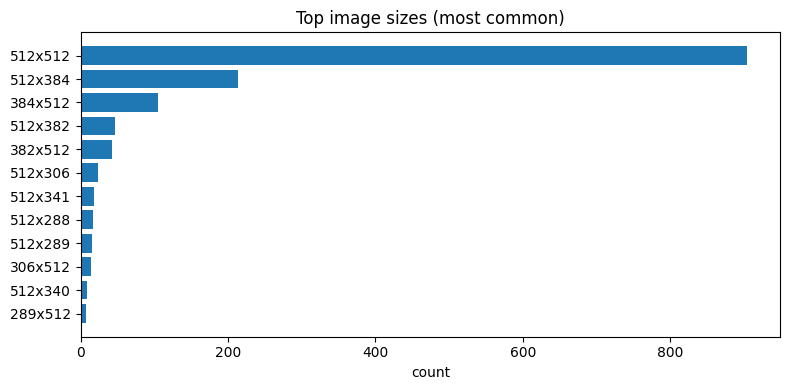

In [11]:
#B: Barplot of top sizes
import matplotlib.pyplot as plt
top=top_sizes.head(12).sort_values('count', ascending=True)
plt.figure(figsize=(8,4))
plt.barh(top['size'], top['count'])
plt.title("Top image sizes (most common)")
plt.xlabel("count")
plt.tight_layout()
plt.show()

In [14]:
#C: percent distribution for report
top_sizes['pct']=100*top_sizes['count']/top_sizes['count'].sum()
top_sizes.head(12)

,size,count,pct
0,512x512,904,60.266667
1,512x384,213,14.200000
2,384x512,105,7.000000
3,512x382,47,3.133333
4,382x512,42,2.800000
5,512x306,23,1.533333
6,512x341,18,1.200000
7,512x288,16,1.066667
8,512x289,15,1.000000
9,306x512,14,0.933333


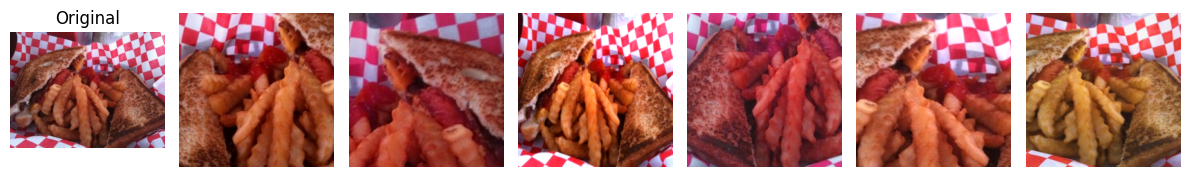

In [8]:
#Cell 6- Visualize augmentations that we'll use during training
import torch
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize, Resize, CenterCrop

IMG_SIZE=224
train_tf_vis=Compose([
    RandomResizedCrop(IMG_SIZE),
    RandomHorizontalFlip(),
    ColorJitter(0.2,0.2,0.2,0.05),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

#pick a sample image (use a random index to show different examples)
import numpy as np
idx=10 if len(train_df) > 10 else 0
sample_path=train_df['fullpath'].iloc[idx]
orig=Image.open(sample_path).convert('RGB')

#show original+6 augmentations
plt.figure(figsize=(12,3))
plt.subplot(1,7,1); plt.imshow(orig); plt.title("Original"); plt.axis('off')

#tensors for unnormalizing
mean=torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std =torch.tensor([0.229,0.224,0.225]).view(3,1,1)

for i in range(6):
    timg=train_tf_vis(orig)  #normalized Tensor CxHxW
    #unnormalize and convert to HxWxC numpy in [0,1]
    t=timg.clone()
    t=t*std+mean
    t=t.permute(1,2,0).numpy()
    t=np.clip(t, 0, 1)
    plt.subplot(1,7,i+2)
    plt.imshow(t)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
#Cell 7- Save small EDA summary (csv) for your report
eda_summary={
    "num_train": [len(train_df)],
    "num_val":   [len(val_df)],
    "num_classes":[len(classes)],
    "img_sample_median_w":[np.median(widths)],
    "img_sample_median_h":[np.median(heights)]
}
pd.DataFrame(eda_summary).to_csv(os.path.join(CSV_DIR, "eda_summary.csv"), index=False)
print("EDA summary saved to", os.path.join(CSV_DIR, "eda_summary.csv"))

EDA summary saved to /content/drive/MyDrive/food-10/food-10/prepared_splits/eda_summary.csv
